In [1]:

from datetime import datetime

import torch
from torch.utils.data import DataLoader

from datasets.LabeledImageDataset import LabeledImageDataset
from models.resnet import Resnet50Model, Resnet18Model
from train import train_classifier
from utils import plot_model_metrics, oversample_dataset
from utils import reduce_dataset, split_dataset, undersample_dataset
from torchvision.transforms import v2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

batch_size = 256
dataset = LabeledImageDataset("data/candidates")
dataset = reduce_dataset(dataset, discard_ratio=0.0)
train_dataset, test_dataset = split_dataset(dataset, train_ratio=0.7)
train_dataset = undersample_dataset(train_dataset)

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=True, )

model = Resnet18Model(hidden_layers=3, units_per_layer=2048, dropout=0.2,focal_alpha=0.02)

print(f"Dataset: {len(train_dataset):,} training, {len(test_dataset):,} testing")


Device: cuda:0
Dataset: 2,322 training, 6,069 testing


In [2]:
print(model)

Resnet18Model(
  (pretrained_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [3]:
print(f"Training starts {datetime.now().isoformat()}")

Training starts 2025-01-22T17:49:39.334572


In [4]:

model = model.to(device)
model, model_metrics = train_classifier(model, train_loader, test_loader, device,
                                        learning_rate=0.0001,
                                        max_epochs=20,
                                        checkpoint_every=1,
                                        eval_every=1)


Epoch 1 training: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


Train: 1/20: loss:0.0031067883828654885


Epoch 1 testing: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


Test: 1/20: loss:0.002248661204551657, accuracy:0.822560572053407, precision:0.2991835154050756, recall:0.8444485463687661, f1:0.4390583838929935, mcc:0.43225364855524573, epoch:0


Epoch 2 training: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Train: 2/20: loss:0.0023563955910503864


Epoch 2 testing: 100%|██████████| 24/24 [00:14<00:00,  1.70it/s]


Test: 2/20: loss:0.002111329081041428, accuracy:0.828082736245396, precision:0.30912843526940476, recall:0.8805714896163224, f1:0.4555142301372008, mcc:0.4556954667488656, epoch:1


Epoch 3 training: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Train: 3/20: loss:0.0019055670942179858


Epoch 3 testing: 100%|██████████| 24/24 [00:13<00:00,  1.74it/s]


Test: 3/20: loss:0.0014649684987186145, accuracy:0.8734883963512892, precision:0.3729514467745376, recall:0.7846709356436813, f1:0.5007689212580091, mcc:0.48205735801008337, epoch:2


Epoch 4 training: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


Train: 4/20: loss:0.0019432282424531877


Epoch 4 testing: 100%|██████████| 24/24 [00:14<00:00,  1.71it/s]


Test: 4/20: loss:0.0014715547004016116, accuracy:0.8720793047882136, precision:0.3693850961798586, recall:0.8051288091880049, f1:0.5013769508949156, mcc:0.4864264488219758, epoch:3


Epoch 5 training: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Train: 5/20: loss:0.0018966694246046246


Epoch 5 testing: 100%|██████████| 24/24 [00:13<00:00,  1.74it/s]


Test: 5/20: loss:0.0016611470055067912, accuracy:0.8540803406998158, precision:0.3459908262591676, recall:0.8606310705753767, f1:0.49173252759860214, mcc:0.4856540785097854, epoch:4


Epoch 6 training: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


Train: 6/20: loss:0.0017042054794728756


Epoch 6 testing: 100%|██████████| 24/24 [00:14<00:00,  1.69it/s]


Test: 6/20: loss:0.0018639369761028017, accuracy:0.8373160177831491, precision:0.3241896430508164, recall:0.8907227089751656, f1:0.4722572556060783, mcc:0.47374059219216624, epoch:5


Epoch 7 training: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Train: 7/20: loss:0.0016712643788196146


Epoch 7 testing: 100%|██████████| 24/24 [00:14<00:00,  1.66it/s]


Test: 7/20: loss:0.001972056920446145, accuracy:0.8371973195787293, precision:0.3201500059926345, recall:0.8881334812134255, f1:0.46556569003583564, mcc:0.468782805537076, epoch:6


Epoch 8 training: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


Train: 8/20: loss:0.0017517694272100926


Epoch 8 testing: 100%|██████████| 24/24 [00:14<00:00,  1.62it/s]


Test: 8/20: loss:0.0014756568610512961, accuracy:0.8718491022099447, precision:0.3645433947082859, recall:0.8171192045025165, f1:0.4996880806115884, mcc:0.48774760956572544, epoch:7


Epoch 9 training: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Train: 9/20: loss:0.0016453230753540992


Epoch 9 testing: 100%|██████████| 24/24 [00:14<00:00,  1.67it/s]


Test: 9/20: loss:0.0015377998885621007, accuracy:0.8596141948664825, precision:0.3517451743189821, recall:0.8396617641978191, f1:0.49424620918999335, mcc:0.4841883145738965, epoch:8


Epoch 10 training: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Train: 10/20: loss:0.0015626036969479174


Epoch 10 testing: 100%|██████████| 24/24 [00:14<00:00,  1.63it/s]


Test: 10/20: loss:0.0016770193081659575, accuracy:0.8539454563766115, precision:0.3463485925672651, recall:0.8544525896419511, f1:0.48750531177777523, mcc:0.4823784206582686, epoch:9


Epoch 11 training: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


Train: 11/20: loss:0.001521076331846416


Epoch 11 testing: 100%|██████████| 24/24 [00:14<00:00,  1.65it/s]


Test: 11/20: loss:0.0018414704002983247, accuracy:0.8476886222375691, precision:0.33637574513550783, recall:0.8704739773475613, f1:0.48305839835699355, mcc:0.47997802309522086, epoch:10


Epoch 12 training: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Train: 12/20: loss:0.0014064891845919191


Epoch 12 testing: 100%|██████████| 24/24 [00:14<00:00,  1.63it/s]


Test: 12/20: loss:0.0019331922861359392, accuracy:0.8340608094498158, precision:0.31897447165984266, recall:0.887920271270073, f1:0.46716016856425785, mcc:0.4678991832227244, epoch:11


Epoch 13 training: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


Train: 13/20: loss:0.0013439324509818106


Epoch 13 testing: 100%|██████████| 24/24 [00:14<00:00,  1.65it/s]


Test: 13/20: loss:0.0021097109565744177, accuracy:0.8323145070787293, precision:0.31402540851195193, recall:0.8859236538558285, f1:0.4598116848726468, mcc:0.4619779674442781, epoch:12


Epoch 14 training: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Train: 14/20: loss:0.001282739598536864


Epoch 14 testing: 100%|██████████| 24/24 [00:14<00:00,  1.62it/s]


Test: 14/20: loss:0.002156715272576548, accuracy:0.8355418393186004, precision:0.32089208742726316, recall:0.8879240392699215, f1:0.46684181610984826, mcc:0.468606529912343, epoch:13


Epoch 15 training: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Train: 15/20: loss:0.0013876866083592176


Epoch 15 testing: 100%|██████████| 24/24 [00:14<00:00,  1.65it/s]


Test: 15/20: loss:0.0019623257879478237, accuracy:0.8435054097605894, precision:0.3291931075512286, recall:0.8759073419663107, f1:0.4746019341052396, mcc:0.4738444991260539, epoch:14


Epoch 16 training: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Train: 16/20: loss:0.0012364668771624565


Epoch 16 testing: 100%|██████████| 24/24 [00:14<00:00,  1.62it/s]


Test: 16/20: loss:0.0018232490304702271, accuracy:0.8489115734346225, precision:0.33605439092110023, recall:0.8672549485854045, f1:0.4823591279565231, mcc:0.4787190892587325, epoch:15


Epoch 17 training: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


Train: 17/20: loss:0.0012351313082035631


Epoch 17 testing: 100%|██████████| 24/24 [00:15<00:00,  1.60it/s]


Test: 17/20: loss:0.001404699845200715, accuracy:0.8904271696593001, precision:0.4111184321309553, recall:0.7832549546656917, f1:0.5356995106972938, mcc:0.5147318851519362, epoch:16


Epoch 18 training: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


Train: 18/20: loss:0.0012677034479565918


Epoch 18 testing: 100%|██████████| 24/24 [00:14<00:00,  1.65it/s]


Test: 18/20: loss:0.0047692344038902474, accuracy:0.6984157386625229, precision:0.21067285906614694, recall:0.9692303770446649, f1:0.3433368370540569, mcc:0.36277230553630213, epoch:17


Epoch 19 training: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Train: 19/20: loss:0.001617321721278131


Epoch 19 testing: 100%|██████████| 24/24 [00:14<00:00,  1.62it/s]


Test: 19/20: loss:0.002079792737883205, accuracy:0.8195400624424494, precision:0.29887636613775065, recall:0.8945112126128526, f1:0.44615994274372933, mcc:0.44954713129892904, epoch:18


Epoch 20 training: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Train: 20/20: loss:0.0012239878356922417


Epoch 20 testing: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]

Test: 20/20: loss:0.0019484497073184077, accuracy:0.8390991885359117, precision:0.323225399555204, recall:0.8788486678373264, f1:0.468747043162991, mcc:0.4688137132219978, epoch:19


Training ends 2025-01-22T17:56:29.036796
Test accuracy: 0.8390991885359117
Test precision: 0.323225399555204
Test recall: 0.8788486678373264
Test f1: 0.468747043162991
Test mcc: 0.4688137132219978


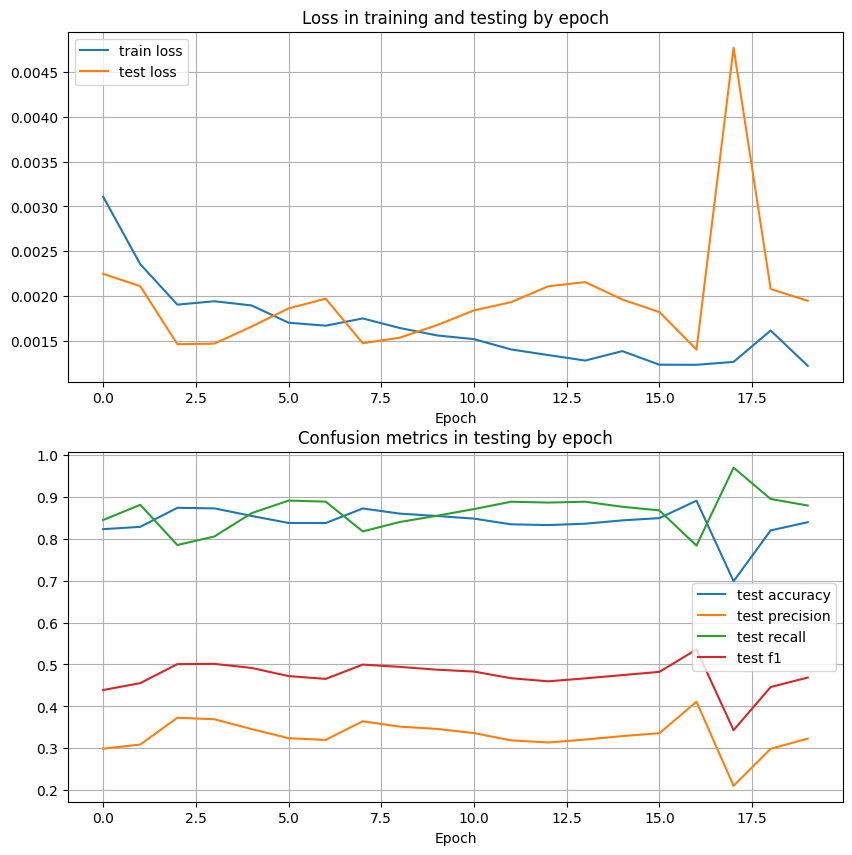

In [5]:

print(f"Training ends {datetime.now().isoformat()}")
for metric in ["accuracy", "precision", "recall", "f1", "mcc"]:
    if len(model_metrics[f"test_{metric}"]) > 0:
        print(f"Test {metric}:", model_metrics[f"test_{metric}"][-1])

plot_model_metrics(model_metrics)

In [6]:
torch.save(model, "model.pickle")